In [17]:
import pulp
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Define the problem
prob = pulp.LpProblem("BasicLP",pulp.LpMinimize)
# Variables
x1 = pulp.LpVariable("x1",0,None)
x2 = pulp.LpVariable("x2",0,None)
# Constraints
prob += 4*x1 + 1*x2 >= 8
prob += 1*x1 + 1*x2 >= 4
prob += 1*x1 + 8*x2 >= 8
prob += x1 + x2 <= 10
# Objectives
def f1(x1,x2):
    return 10*x1 + 1*x2
def f2(x1,x2):
    return 1*x1 + 10*x2
def F(alpha):
    return alpha*f1(x1,x2) + (1-alpha)*f2(x1,x2)

# Solve the problem for different values of lambda
alphas = np.linspace(0,1,10)
solutions = []
for alpha in alphas:
    prob += F(alpha)
    prob.solve()
    solutions.append([x1.varValue,x2.varValue])
solutions = np.unique(solutions, axis=0).tolist()

number_of_solutions = len(solutions)
solution_dict = {f'S{i+1}': solutions[i] for i in range(number_of_solutions)}
print(solution_dict)

{'S1': [0.0, 8.0], 'S2': [1.3333333, 2.6666667], 'S3': [3.4285714, 0.57142857], 'S4': [8.0, 0.0]}


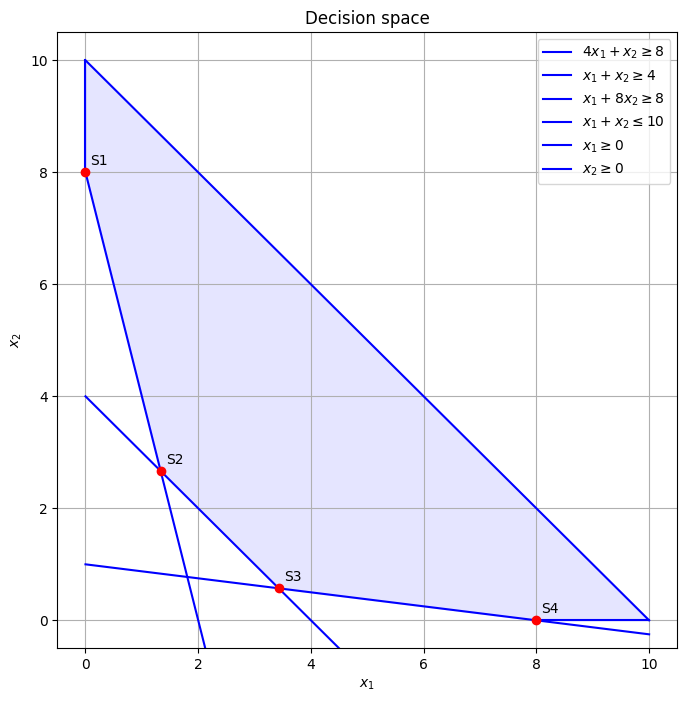

In [19]:
# Representing the LP on the decision space
# Define the range for x1
x1 = np.linspace(0, 10, 400)

# Define the constraints as functions of x1
x2_1 = (8 - 4*x1) / 1
x2_2 = 4 - x1
x2_3 = (8 - 1*x1) / 8
x2_4 = 10 - x1

# Create the plot
plt.figure(figsize=(8, 8))
plt.plot(x1, x2_1, 'b', label=r'$4x_1 + x_2 \geq 8$')
plt.plot(x1, x2_2, 'b', label=r'$x_1 + x_2 \geq 4$')
plt.plot(x1, x2_3, 'b', label=r'$x_1 + 8x_2 \geq 8$')
plt.plot(x1, x2_4, 'b', label=r'$x_1 + x_2 \leq 10$')

# Add the restriction lines for x1 >= 0 and x2 >= 0 within the feasible region
plt.plot([0, 0], [8, 10], 'b', label=r'$x_1 \geq 0$')
plt.plot([8, 10], [0, 0], 'b', label=r'$x_2 \geq 0$')

# Fill the feasible region
plt.fill_between(x1, np.maximum.reduce([x2_1, x2_2, x2_3, np.zeros_like(x1)]), x2_4, where=(x1 + x2_4 <= 10) & (x1 >= 0), color='b', alpha=0.1)

# Plot the solutions
for key, value in solution_dict.items():
    plt.scatter(value[0], value[1], color='red', zorder=5)
    plt.annotate(key, (value[0], value[1]), textcoords="offset points", xytext=(10,5), ha='center')

# Set the limits for x and y axes
plt.xlim(-0.5, 10.5)
plt.ylim(-0.5, 10.5)

# Add labels and legend
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Decision space')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

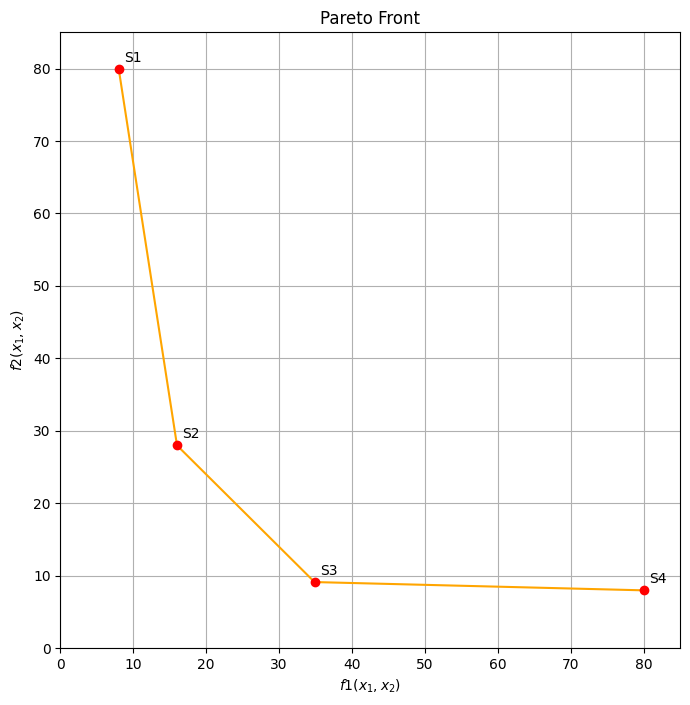

In [20]:
# Evaluate the solutions
evaluated_solutions = {}
for key, (x1, x2) in solution_dict.items():
    evaluated_solutions[key] = (f1(x1, x2), f2(x1, x2))

# Extract the evaluated values for plotting
f1_values = [val[0] for val in evaluated_solutions.values()]
f2_values = [val[1] for val in evaluated_solutions.values()]

# Sort the evaluated solutions for plotting lines
sorted_evaluated_solutions = sorted(evaluated_solutions.values())

# Plot the Pareto front
plt.figure(figsize=(8, 8))
plt.scatter(f1_values, f2_values, color='red', zorder=5)

# Annotate the points
for key, (f1_val, f2_val) in evaluated_solutions.items():
    plt.annotate(key, (f1_val, f2_val), textcoords="offset points", xytext=(10, 5), ha='center')

# Add lines connecting the evaluated points
for i in range(len(sorted_evaluated_solutions) - 1):
    plt.plot([sorted_evaluated_solutions[i][0], sorted_evaluated_solutions[i+1][0]],
             [sorted_evaluated_solutions[i][1], sorted_evaluated_solutions[i+1][1]], 'orange')

# Set the limits for x and y axes
plt.xlim(0, 85)
plt.ylim(0, 85)

# Add labels and title
plt.xlabel(r'$f1(x_1, x_2)$')
plt.ylabel(r'$f2(x_1, x_2)$')
plt.title('Pareto Front')
plt.grid(True)

# Show the plot
plt.show()

In [21]:
from math import sqrt

num_ref_points = 10

f1_anchor_point = (8.0, 80.0)
f2_anchor_point = (80.0, 8.0)
CHIM_long = sqrt((f2_anchor_point[0] - f1_anchor_point[0])**2 + (f2_anchor_point[1] - f1_anchor_point[1])**2)
CHIM_dir = (f2_anchor_point[0]-f1_anchor_point[0])/CHIM_long, (f2_anchor_point[1] - f1_anchor_point[1])/CHIM_long # from f1_anchor_point to f2_anchor_point
normal = (CHIM_dir[1], -CHIM_dir[0])

def get_ref_point(i):
    return (f1_anchor_point[0]+CHIM_dir[0]*CHIM_long*i/(num_ref_points-1), f1_anchor_point[1]+CHIM_dir[1]*CHIM_long*i/(num_ref_points-1))

q_list = [get_ref_point(i) for i in range(num_ref_points)]
representative_solutions = {} # key: (x1, x2), value: (f1, f2)

def solve_NBI_subproblem(q):
    probNBI = pulp.LpProblem("NBISubproblem", pulp.LpMaximize)
    # Variables
    x1 = pulp.LpVariable("x1", 0, None)
    x2 = pulp.LpVariable("x2", 0, None)
    t = pulp.LpVariable("t", 0, None)  

    # Original constraints
    probNBI += 4*x1 + 1*x2 >= 8
    probNBI += 1*x1 + 1*x2 >= 4
    probNBI += 1*x1 + 8*x2 >= 8
    probNBI += x1 + x2 <= 10

    # NBI constraint
    probNBI += q[0] + t*normal[0] == (10*x1 + 1*x2) 
    probNBI += q[1] + t*normal[1] == (1*x1 + 10*x2)

    probNBI += t
    probNBI.solve()
    return (x1.varValue, x2.varValue)

for q in q_list:
    solNBI = solve_NBI_subproblem(q)
    representative_solutions[solNBI] = (f1(solNBI[0], solNBI[1]), f2(solNBI[0], solNBI[1]))

print(representative_solutions)

{(0.0, 8.0): (8.0, 80.0), (0.35555556, 6.5777778): (10.1333334, 66.13333356), (0.71111111, 5.1555556): (12.2666667, 52.26666710999999), (1.0666667, 3.7333333): (14.4000003, 38.399999699999995), (1.5555556, 2.4444444): (18.000000399999998, 25.999999600000002), (2.4444444, 1.5555556): (25.999999600000002, 18.000000399999998), (3.3333333, 0.66666667): (33.99999967, 10.0), (4.8395062, 0.39506173): (48.79012373, 8.7901235), (6.4197531, 0.19753086): (64.39506186, 8.3950617), (8.0, -9.0988945e-13): (79.99999999999909, 7.9999999999909015)}


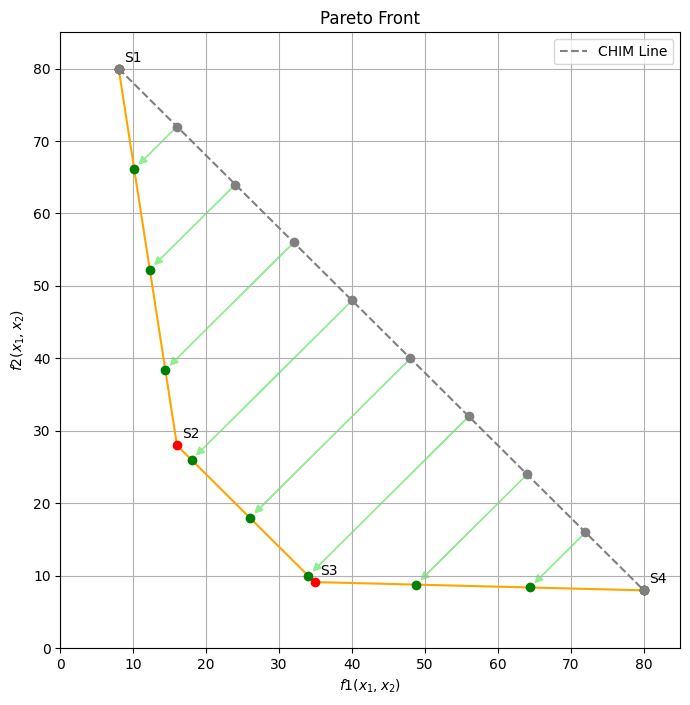

In [22]:
# Evaluate the solutions
evaluated_solutions = {}
for key, (x1, x2) in solution_dict.items():
    evaluated_solutions[key] = (f1(x1, x2), f2(x1, x2))

# Extract the evaluated values for plotting
f1_values = [val[0] for val in evaluated_solutions.values()]
f2_values = [val[1] for val in evaluated_solutions.values()]

# Sort the evaluated solutions for plotting lines
sorted_evaluated_solutions = sorted(evaluated_solutions.values())

# Plot the Pareto front
plt.figure(figsize=(8, 8))
plt.scatter(f1_values, f2_values, color='red', zorder=5)

# Annotate the points
for key, (f1_val, f2_val) in evaluated_solutions.items():
    plt.annotate(key, (f1_val, f2_val), textcoords="offset points", xytext=(10, 5), ha='center')

# Add lines connecting the evaluated points
for i in range(len(sorted_evaluated_solutions) - 1):
    plt.plot([sorted_evaluated_solutions[i][0], sorted_evaluated_solutions[i+1][0]],
             [sorted_evaluated_solutions[i][1], sorted_evaluated_solutions[i+1][1]], 'orange')

# Plot the representative solutions in green
rep_f1_values = [val[0] for val in representative_solutions.values()]
rep_f2_values = [val[1] for val in representative_solutions.values()]
plt.scatter(rep_f1_values, rep_f2_values, color='green', zorder=5)

# Plot the CHIM line as a discontinuous gray line
chim_x = [f1_anchor_point[0], f2_anchor_point[0]]
chim_y = [f1_anchor_point[1], f2_anchor_point[1]]
plt.plot(chim_x, chim_y, 'gray', linestyle='--', label='CHIM Line')

# Plot the reference points on the CHIM line as gray dots
q_f1_values = [q[0] for q in q_list]
q_f2_values = [q[1] for q in q_list]
plt.scatter(q_f1_values, q_f2_values, color='gray', zorder=5)

# Plot the normal vectors as light green arrows
for q, rep in zip(q_list[1:-1], list(representative_solutions.values())[1:-1]):
    arrow_dir = (rep[0] - q[0], rep[1] - q[1])
    arrow_norm = sqrt((rep[0] - q[0])**2 + (rep[1] - q[1])**2)
    arrow_dx = (rep[0] - q[0]) - 2*arrow_dir[0]/arrow_norm
    arrow_dy = (rep[1] - q[1]) - 2*arrow_dir[1]/arrow_norm
    plt.arrow(q[0], q[1], arrow_dx, arrow_dy, head_width=1, head_length=1, fc='lightgreen', ec='lightgreen')

# Set the limits for x and y axes
plt.xlim(0, 85)
plt.ylim(0, 85)

# Add labels and title
plt.xlabel(r'$f1(x_1, x_2)$')
plt.ylabel(r'$f2(x_1, x_2)$')
plt.title('Pareto Front')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

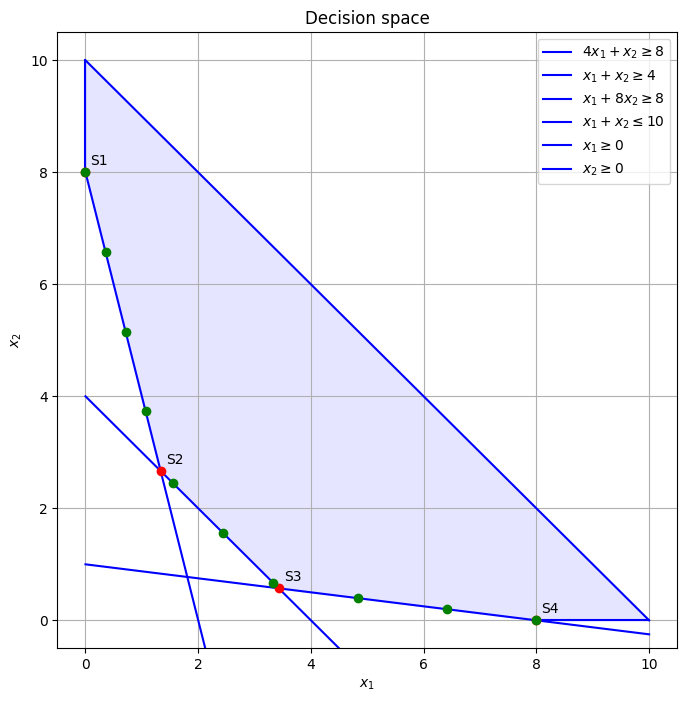

In [23]:
# Representing the LP on the decision space
# Define the range for x1
x1 = np.linspace(0, 10, 400)

# Define the constraints as functions of x1
x2_1 = (8 - 4*x1) / 1
x2_2 = 4 - x1
x2_3 = (8 - 1*x1) / 8
x2_4 = 10 - x1

# Create the plot
plt.figure(figsize=(8, 8))
plt.plot(x1, x2_1, 'b', label=r'$4x_1 + x_2 \geq 8$')
plt.plot(x1, x2_2, 'b', label=r'$x_1 + x_2 \geq 4$')
plt.plot(x1, x2_3, 'b', label=r'$x_1 + 8x_2 \geq 8$')
plt.plot(x1, x2_4, 'b', label=r'$x_1 + x_2 \leq 10$')

# Add the restriction lines for x1 >= 0 and x2 >= 0 within the feasible region
plt.plot([0, 0], [8, 10], 'b', label=r'$x_1 \geq 0$')
plt.plot([8, 10], [0, 0], 'b', label=r'$x_2 \geq 0$')

# Fill the feasible region
plt.fill_between(x1, np.maximum.reduce([x2_1, x2_2, x2_3, np.zeros_like(x1)]), x2_4, where=(x1 + x2_4 <= 10) & (x1 >= 0), color='b', alpha=0.1)

# Plot the solutions
for key, value in solution_dict.items():
    plt.scatter(value[0], value[1], color='red', zorder=5)
    plt.annotate(key, (value[0], value[1]), textcoords="offset points", xytext=(10,5), ha='center')

# Plot the representative solutions in green
for key, value in representative_solutions.items():
    plt.scatter(key[0], key[1], color='green', zorder=5)
    #plt.annotate(f'Rep {key}', (key[0], key[1]), textcoords="offset points", xytext=(10,5), ha='center')

# Set the limits for x and y axes
plt.xlim(-0.5, 10.5)
plt.ylim(-0.5, 10.5)

# Add labels and legend
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Decision space')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [24]:
new_list = list(representative_solutions.values())[1:-1]
new_list

[(10.1333334, 66.13333356),
 (12.2666667, 52.26666710999999),
 (14.4000003, 38.399999699999995),
 (18.000000399999998, 25.999999600000002),
 (25.999999600000002, 18.000000399999998),
 (33.99999967, 10.0),
 (48.79012373, 8.7901235),
 (64.39506186, 8.3950617)]